2DOF :  2 angles
Circular obstacles that it cannot bump into
1. Calculate config space for these two robots 
2. Make arms rectangular 
3. You can decide length and width of arms
4. 3 spheres obstacles -> you decide diameter and location
5. Calculate configuration space by randomly sampling and see if it collides
    1. Sample every combination 
    2. Get an image  - > (workspace, config_space)
6.  Train from work space to estimate config space
    1. See if shape 


In [163]:
import math
from shapely.geometry import Polygon,Point,LineString,MultiPoint
from shapely import affinity
import matplotlib.pyplot as plt

In [166]:
def round_point(point):
    return Point(round(point.x,4),round(point.y,4))

def round_polygon(ls):
    linestring = []
    for point in ls.exterior.coords:
        linestring.append(Point(round(point[0],4),round(point[1],4)))
    return MultiPoint(linestring).convex_hull

def round_line_string(ls):
    linestring = []
    for point in ls.boundary.geoms:
        linestring.append(Point(round(point.x,4),round(point.y,4)))
    return LineString(linestring)

def midpoint(p1, p2):
    p1 = Point(p1)
    p2 = Point(p2)
    midpt =  Point((p1.x+p2.x)/2, (p1.y+p2.y)/2)
    return tuple([midpt.x,midpt.y])

# two functions for plotting obstacles
def plot_coords(coords):
    pts = list(coords)
    x, y = zip(*pts)
    plt.plot(x,y)

def plot_polys(polys):
    for poly_id,poly in enumerate(polys):
        plot_coords(poly.exterior.coords)
        plt.fill_between(*poly.exterior.xy, alpha=.5,label=f"obstacle {poly_id+1}")


In [230]:
def plot(q1,q2,robot_arm1_og,total_arm_og,obstacles,title="Workspace"):
    arm_1_rot = q1
    arm1_joint = (0,0)
    robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,arm1_joint))
    total_a = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,arm1_joint))

    total_a_coords = set([*total_a.exterior.coords])
    arm_1_coords = set([*robot_arm1.exterior.coords])
    upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
    upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

    poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))
    mid = midpoint(poossible_joints[0],poossible_joints[1])

    upper_arm_joint = mid

    upper_arm_rotate = affinity.rotate(upper_arm,-q2,upper_arm_joint)

    fig,ax = plt.subplots(figsize=(5,5))
    ax.fill(*robot_arm1.exterior.xy,color='green')
    ax.plot(arm1_joint[0],arm1_joint[1],marker="o",markerfacecolor="black",label='q1 - [0,360]')
    ax.plot(upper_arm_joint[0],upper_arm_joint[1],marker="o",markerfacecolor="black",label='q2 - [0,180]')
    ax.fill(*upper_arm_rotate.exterior.xy,color='blue')

    ax.set_title(title)
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    # ax.set_aspect( 1 )
    plot_polys(obstacles)
    ax.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    
def plot_collision(q1,q2,arm_1,total_arm,obstacles):
    plot(q1,q2,arm_1,total_arm,obstacles,title=f"Collision at q1={q1},q2={q2}")

In [231]:
robot_arm1_og = MultiPoint(list([Point(0,0),Point(2,0),Point(0,.5),Point(2,.5)])).convex_hull
total_arm_og = MultiPoint(list([Point(0,0),Point(4,0),Point(0,.5),Point(4,.5)])).convex_hull
obst_1 = Point(4,1).buffer(.5)
obst_2 = Point(3,0).buffer(.5)
obst_3 = Point(2,4).buffer(.5)

obstacles = [obst_1,obst_2,obst_3]

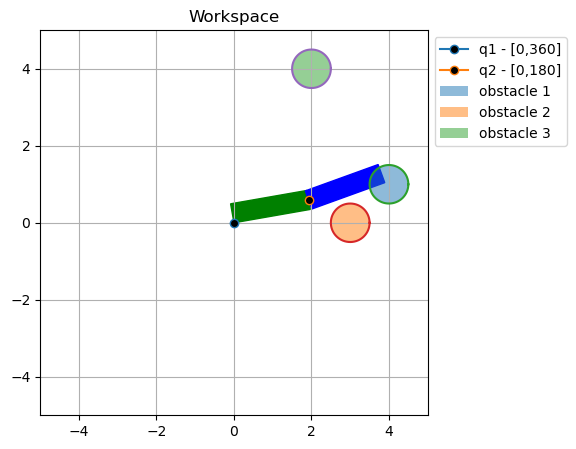

In [232]:
plot(10,-10,robot_arm1_og,total_arm_og,obstacles)

In [233]:
def calculate_c_obs(c_robot_arm1,c_total_arm,q_1,q_2,obst,ref_pt=(0,0)):
    c_pts = []
    for i in range(q_1[0],q_1[1]+1):
        c_arm_1_rotated = round_polygon(affinity.rotate(c_robot_arm1,i,ref_pt))
        c_total_arm_rotated = round_polygon(affinity.rotate(c_total_arm,i,ref_pt))

        c_total_arm_coords = {*c_total_arm_rotated.exterior.coords}
        c_arm_1_rotated_coords = {*c_arm_1_rotated.exterior.coords}
        c_upper_arm_coords = c_total_arm_coords.difference(c_arm_1_rotated_coords).union(c_arm_1_rotated_coords.difference(c_total_arm_coords))
        c_upper_arm = MultiPoint(list(c_upper_arm_coords)).convex_hull

        c_possible_joints = list(c_arm_1_rotated_coords.intersection(c_upper_arm_coords))
        assert len(c_possible_joints) == 2, f"{i},{j}"
        c_upper_arm_joint = midpoint(c_possible_joints[0],c_possible_joints[1])

        for j in range(q_2[0],q_2[1]-1,-1):
            c_arm_2_rotated = round_polygon(affinity.rotate(c_upper_arm,j,c_upper_arm_joint))
            for obs_id,o in enumerate(obst):
                if c_arm_2_rotated.intersects(o) or c_arm_1_rotated.intersects(o):
                    c_pts.append((i,abs(j),obs_id))
                    break
    return c_pts

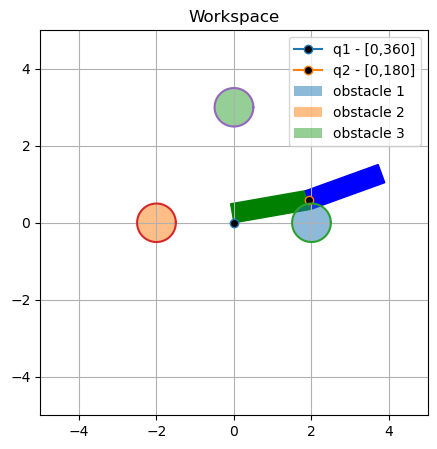

In [234]:
robot_arm1_og = MultiPoint(list([Point(0,0),Point(2,0),Point(0,.5),Point(2,.5)])).convex_hull
total_arm_og = MultiPoint(list([Point(0,0),Point(4,0),Point(0,.5),Point(4,.5)])).convex_hull
obst_1 = Point(2,0).buffer(.5)
obst_2 = Point(-2,0).buffer(.5)
obst_3 = Point(0,3).buffer(.5)

obstacles = [obst_1,obst_2,obst_3]
plot(10,-10,robot_arm1_og,total_arm_og,obstacles)

In [235]:
c_obs = calculate_c_obs(robot_arm1_og,total_arm_og,[0,359],[0,-359],obstacles)
print(f"num collisions detected: {len(c_obs)}")

num collisions detected: 52140


[]

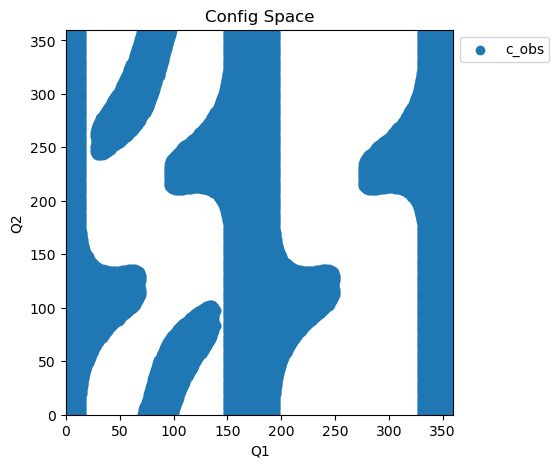

In [236]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Config Space")
ax.set_xlim([0,360])
ax.set_ylim([0,360])
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
x_s = list(map(lambda pt: pt[0],c_obs))
y_s = list(map(lambda pt: pt[1],c_obs))
ax.scatter(x_s,y_s,label='c_obs')
ax.legend(bbox_to_anchor=(1, 1))
plt.plot()

[]

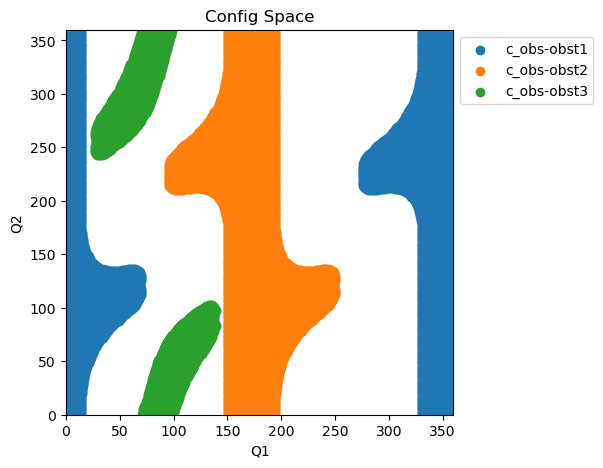

In [237]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Config Space")
ax.set_xlim([0,360])
ax.set_ylim([0,360])
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')

def group_c_obs_by_obs_id(c_obs):
    res = [[],[],[]]
    for c in c_obs:
        if c[-1] == 0: 
            res[0].append(c[:2])
        elif c[-1] == 1:
            res[1].append(c[:2])
        elif c[-1] == 2:
            res[2].append(c[:2])
    return res

grouped_cobs = group_c_obs_by_obs_id(c_obs)

for group_id,group in enumerate(grouped_cobs):
    x_s = list(map(lambda pt: pt[0],group))
    y_s = list(map(lambda pt: pt[1],group))
    ax.scatter(x_s,y_s,label=f"c_obs-obst{group_id+1}")
ax.legend(bbox_to_anchor=(1, 1))
plt.plot()

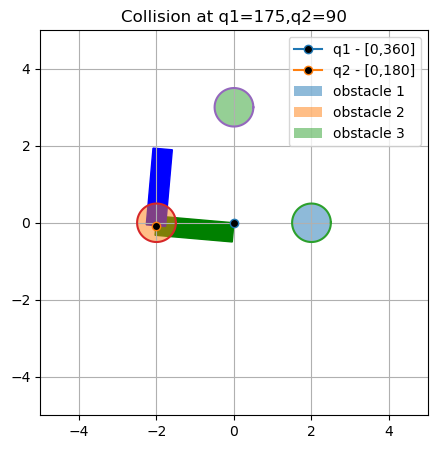

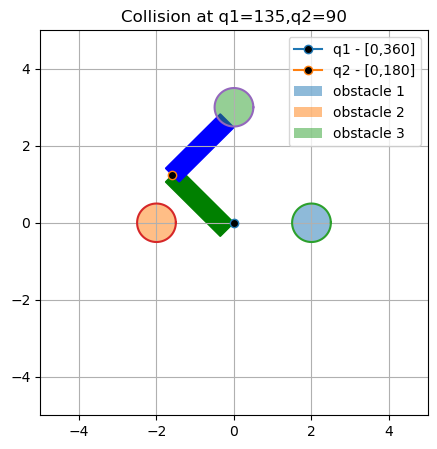

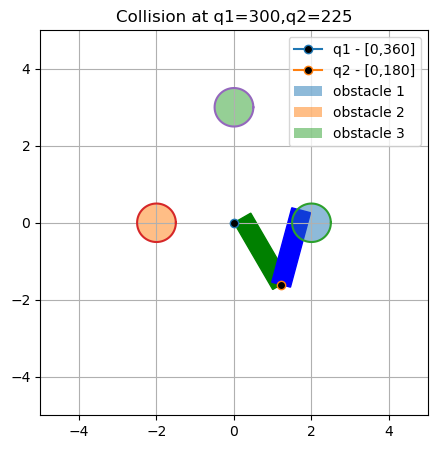

In [238]:
plot_collision(175,90,robot_arm1_og,total_arm_og,obstacles)
plot_collision(135,90,robot_arm1_og,total_arm_og,obstacles)
plot_collision(300,225,robot_arm1_og,total_arm_og,obstacles)